# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import time
import random

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

# machine learning
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score


# Functions

In [2]:
# GridSearch Function
def pipeline_gridsearch(pipe, pipe_params, X_train, y_train):
    tscv = TimeSeriesSplit(n_splits = 5) # Time Series Split
    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=tscv, n_jobs = -1, scoring='f1')
    gs.fit(X_train, y_train)
    print('Best f1 Score: ' + str(gs.best_score_)) # best_score_ is gridsearch's function
    print("Best Parameters: " + str(gs.best_params_))# best_params_ is gridsearch's function

In [3]:
# Testing the Model
def fit_and_test(best_feature, best_model, X_train, X_test, y_train, y_test):
    X_train_featured = best_feature.fit_transform(X_train)
    X_test_featured = best_feature.transform(X_test)
    best_model.fit(X_train_featured, y_train)
    tscv = TimeSeriesSplit(n_splits = 5) # Time Series Split
    train_score_val = cross_val_score(best_model, X_train, y_train, cv=tscv)
    train_score = best_model.score(X_train_featured, y_train)
    test_score = best_model.score(X_test_featured, y_test)
    
#     if best_model == best_logit:
#         features = pd.DataFrame(list(zip(X_test.columns, best_model.coef_)), columns = ['Features', 'Coefficient'])
#     features = pd.DataFrame(list(zip(X_test.columns, best_model.feature_importances_)), columns = ['Features', 'Importance'])
    
    predict = best_model.predict(X_test_featured)
    report = classification_report(y_test, best_model.predict(X_test_featured))
    con_matrix = confusion_matrix(y_test, predict)
    tn, fp, fn, tp = confusion_matrix(y_test, predict).ravel()
    probabilities = best_model.predict_proba(X_test_featured)
    f1 = f1_score(y_test, predict)
    precision = precision_score(y_test, predict)
    recall = recall_score(y_test, predict)
    
    
    #print('{} features were selected'.format(len(selected_features)))
    print('Cross Validated Mean Train Score is: {}'.format(train_score_val.mean()))
    print('Train Score is: {}'.format(train_score))
    print('Test Score is: {}'.format(test_score))
    print('f1 Score is: {}'.format(f1))
    print('Precision is: {}'.format(precision))
    print('Recall is: {}'.format(recall))
    
   
    return (predict, con_matrix, report, tn, fp, fn, tp, probabilities) 

# Preparing the Data

In [4]:
# Import Data
df = pd.read_csv('../datasets/features_data_classification.csv')

In [5]:
df['local_time'] = pd.to_datetime(df['local_time'])

In [6]:
df.sort_values('local_time', inplace = True)

### Baseline Accuracy

In [7]:
df.shape

(10100, 232)

In [8]:
# Check Baseline Accuracy
df['reversal'].value_counts(normalize = True)

0    0.959406
1    0.040594
Name: reversal, dtype: float64

Our Dataset is Heavily Unbalanced. However, since it is a timeseries data, we should not oversample/undersample.

## One-Hot_Encoding

In [9]:
df_final = pd.get_dummies(data = df, columns = ['stock'], drop_first = False)

In [10]:
# Drop some Columns before Spliting into train/test set, I will drop local time and keep Epoch time
df_final = df_final.drop(columns =['local_time'])

## Create X Features and Y Target Label

In [11]:
X = df_final.drop(columns = 'reversal')
y = df_final['reversal']
X.shape, y.shape

((10100, 239), (10100,))

## Train-Test Split

Because we are dealing with time series data, the usual train test split operation cannot be done. To split the data, we have to split it into the top x% and 1-x%

In [12]:
# Train Test Split to create Training Set and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle = False)

In [13]:
# Split to create Training Set and Validation Set for PCA
X_training, X_val, y_training, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = False)

The train set will be further split for GridSearch using the TimeSeriesSplit method. 

Training and validation set will only be used for PCA to select features.

# Feature Selection

We will be utilising PCA to select the Top features to be used for our Modelling.

We will be testing the models using all the features and using the top feature to see which method is better for classification.

In [14]:
# Create Pipeline for PCA
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('pca', PCA())
])

In [15]:
# Parameters to decide for PCA
pipe_params = {
    'pca__n_components': [120, 180, 210, 239], # find out how many max features is better
    'pca__tol': [0.3,0.4,0.5,0.6]}

In [16]:
# GridSearch CV
tscv = TimeSeriesSplit(n_splits = 5) # Time Series Split
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=tscv, n_jobs = -1)
gs.fit(X_training, y_training)
print('Best Score: ' + str(gs.best_score_)) # best_score_ is gridsearch's function
print("Best Parameters: " + str(gs.best_params_))# best_params_ is gridsearch's function

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:764: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


Best Score: 346.71919563520834
Best Parameters: {'pca__n_components': 180, 'pca__tol': 0.5}


PCA Score returns the average log-likelihood of all samples. Therefore it value would not be between 0 to 1. The Higher the log-likelihood, the better.

In [17]:
ss = StandardScaler()
pca = PCA(n_components = 180, tol = 0.6)

In [18]:
p_train = ss.fit_transform(X_training)
p_val = ss.transform(X_val)

In [19]:
p_train = pca.fit_transform(p_train)
p_val = pca.transform(p_val)

In [20]:
# Pull the Explained Variance Attribute
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:200],3)}')
print('')
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:200],3)}')

Explained variance (first 20 components): [0.345 0.181 0.057 0.038 0.027 0.025 0.018 0.018 0.017 0.015 0.015 0.014
 0.013 0.012 0.01  0.009 0.009 0.008 0.008 0.007 0.006 0.006 0.006 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.004 0.004 0.004 0.004 0.004 0.004
 0.003 0.003 0.003 0.003 0.003 0.003 0.002 0.002 0.002 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   

In [21]:
# number of components
n_pcs= pca.components_.shape[0]
# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

In [22]:
# get the names
most_important_names = [X.columns]
most_important_names[0][42]
# print pca and feature names
pca_feature = list(zip(most_important, most_important_names[0][most_important],var_exp))
pca_feature

[(73, 'ema7', 0.3454103372436971),
 (134, 'momentum_rsi_lag_1', 0.1812905582272195),
 (186, 'trend_macd_signal_lag_2', 0.05676052773206538),
 (111, 'trend_macd_diff_lag_1', 0.03808882335594948),
 (83, 'pct_change_lag_1', 0.02704488707527858),
 (169, 'volume_nvi_lag_2', 0.02540793552034124),
 (159, 'pct_change_lag_2', 0.018058877406124798),
 (45, 'trend_mass_index', 0.0179932303117339),
 (9, 'volatility', 0.016708334137134812),
 (144, 'others_dr_lag_1', 0.015389601512333508),
 (197, 'trend_mass_index_lag_2', 0.014840906874306264),
 (220, 'others_dr_lag_2', 0.014213879024773746),
 (8, 'return', 0.012584777882347313),
 (131, 'trend_aroon_up_lag_1', 0.011695605919836153),
 (89, 'volume_fi_lag_1', 0.010128609467432957),
 (12, 'volume_cmf', 0.00906878059251745),
 (13, 'volume_fi', 0.008802426534895335),
 (230, 'stock_CRM', 0.007849524033757674),
 (166, 'volume_em_lag_2', 0.007771254160944325),
 (230, 'stock_CRM', 0.00729350546268118),
 (123, 'trend_dpo_lag_1', 0.0064831752232488654),
 (31, '

We will be using all the stock features regardless of coefficient because I want the model to be able to handle all the different stocks when applied to.

For the rest of the features we will use, 27/52/77 and all features to see which method performs best.

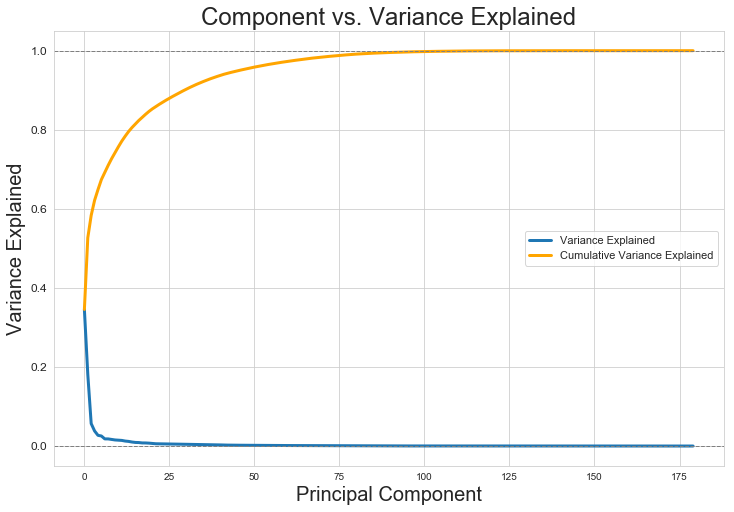

In [23]:
# Plot the variance explained (and cumulative variance explained).
# Set figure size.
plt.figure(figsize=(12,8))
# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')
# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')
# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')
# Set the limits of the axes.
#plt.xlim([-1,21])
#plt.ylim([-0.01,1.01])
# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)
# Make the tick labels bigger
#plt.xticks(range(0, 21, 5), range(1, 22, 5), fontsize=12)
plt.yticks(fontsize=12)
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

About 15 features would explain about 80%+ variance and 50 features would explain 95% variance of our features. As mentioned above, we will use 27/52/77/all (including all stock features) features for modelling.

In [24]:
# Get Features Prepared for Modelling
top_feature_col_27 = [x[1] for x in pca_feature][:16] # 27 Features
top_feature_col_52 = [x[1] for x in pca_feature][:65] # 52 Features
top_feature_col_77 = [x[1] for x in pca_feature][:103] # 77 Features

In [25]:
# List of Stock Columns and time
stock = ['stock_AAPL',
       'stock_CRM', 'stock_DIS', 'stock_FB', 'stock_GM', 'stock_INTC',
       'stock_NKE', 'stock_TRIP', 'stock_TWTR', 'stock_V', 'time']

In [26]:
# Add Stocks into Features Prepared
top_feature_col_27.extend(stock)
top_feature_col_52.extend(stock)
top_feature_col_77.extend(stock)

In [27]:
# Remove any Duplicates
top_feature_col_27 = list(set(top_feature_col_27))
top_feature_col_52 = list(set(top_feature_col_52))
top_feature_col_77 = list(set(top_feature_col_77))

In [28]:
# Check Number of Features
print(len(top_feature_col_27))
print(len(top_feature_col_52))
print(len(top_feature_col_77))

27
53
75


# Model Prep

We will perform GridSearch and Validation tests on these Models:

- Logistic Regression
- Random Forest
- KNearestNeighbor
- SVM
- Naive Bayes
- GLM Poisson
- Ada Boost
- Gradient Boost
- XGBoost
- Voting Classifier

We would not be using **Accuracy** as our Metric because our dataset is heavily unbalanced. Getting True Positives is **Important** for this model. Hence we will use F1 Score as our Metric.

## Logistic Regression

### GridSearch

In [29]:
pipe_log = Pipeline([
    ('ss', StandardScaler()),
    ('logit', LogisticRegression())
])

In [30]:
pipe_params_log = {  
    'logit__C' : [1,2], 
    'logit__class_weight' : ['balanced', None], # Solve Unbalanced dataset
    'logit__penalty' : ['l1','l2']
}

In [31]:
# 27 Features
pipeline_gridsearch(pipe_log, pipe_params_log, X_train[top_feature_col_27], y_train)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best f1 Score: 0.1024400333055721
Best Parameters: {'logit__C': 1, 'logit__class_weight': 'balanced', 'logit__penalty': 'l1'}


In [32]:
# 52 Features
pipeline_gridsearch(pipe_log, pipe_params_log, X_train[top_feature_col_52], y_train)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best f1 Score: 0.11647976403753227
Best Parameters: {'logit__C': 1, 'logit__class_weight': 'balanced', 'logit__penalty': 'l1'}


In [33]:
# 77 Features
pipeline_gridsearch(pipe_log, pipe_params_log, X_train[top_feature_col_77], y_train)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best f1 Score: 0.12106304627171698
Best Parameters: {'logit__C': 1, 'logit__class_weight': 'balanced', 'logit__penalty': 'l1'}


### Test Model

In [34]:
ss = StandardScaler()

In [35]:
# Best Logit Models
best_logit_27 = LogisticRegression(C = 2, class_weight = "balanced", penalty = 'l2', n_jobs = -1)
best_logit_52 = LogisticRegression(C = 2, class_weight = "balanced", penalty = 'l2', n_jobs = -1)
best_logit_77 = LogisticRegression(C = 1, class_weight = "balanced", penalty = 'l1', n_jobs = -1)

#### Top 27 Features

In [36]:
# Score for Top 27 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_logit_27, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear

Cross Validated Mean Train Score is: 0.6380386329866271
Train Score is: 0.6172029702970298
Test Score is: 0.5475247524752476
f1 Score is: 0.07302231237322515
Precision is: 0.039779005524861875
Recall is: 0.4444444444444444


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [37]:
con_matrix

array([[1070,  869],
       [  45,   36]])

#### Top 52 Features

In [38]:
# Score for Top 52 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_logit_52, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear

Cross Validated Mean Train Score is: 0.6328380386329867
Train Score is: 0.691089108910891
Test Score is: 0.6386138613861386
f1 Score is: 0.11192214111922141
Precision is: 0.0620782726045884
Recall is: 0.5679012345679012


In [39]:
con_matrix

array([[1244,  695],
       [  35,   46]])

#### Top 77 Features

In [40]:
# Score for Top 77 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_logit_77, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/svm/ba

Cross Validated Mean Train Score is: 0.6936106983655275
Train Score is: 0.6954207920792079
Test Score is: 0.6777227722772278
f1 Score is: 0.12382234185733515
Precision is: 0.06948640483383686
Recall is: 0.5679012345679012


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [41]:
con_matrix

array([[1323,  616],
       [  35,   46]])

## Random Forest

### GridSearch

In [42]:
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

In [43]:
pipe_params_rf = {
    'rf__n_estimators' : [25,30,35],
    'rf__max_features' : ['auto' ,10, 27],
    'rf__max_depth' : [15,25,30,35],
    'rf__class_weight': ['balanced', None]
}

In [44]:
# 27 Features
pipeline_gridsearch(pipe_rf, pipe_params_rf, X_train[top_feature_col_27], y_train)

Best f1 Score: 0.0349318011321012
Best Parameters: {'rf__class_weight': None, 'rf__max_depth': 30, 'rf__max_features': 27, 'rf__n_estimators': 25}


In [45]:
# 52 Features
pipeline_gridsearch(pipe_rf, pipe_params_rf, X_train[top_feature_col_52], y_train)

Best f1 Score: 0.02512152085291075
Best Parameters: {'rf__class_weight': None, 'rf__max_depth': 15, 'rf__max_features': 27, 'rf__n_estimators': 35}


In [46]:
# 77 Features
pipeline_gridsearch(pipe_rf, pipe_params_rf, X_train[top_feature_col_77], y_train)

Best f1 Score: 0.029987936362400717
Best Parameters: {'rf__class_weight': None, 'rf__max_depth': 35, 'rf__max_features': 27, 'rf__n_estimators': 25}


### Test Model

In [47]:
# Model with Best Parameters
best_rf_27 = RandomForestClassifier(class_weight = None, n_jobs = -1, max_depth = 30, max_features = 10, n_estimators = 25)
best_rf_52 = RandomForestClassifier(class_weight = None, n_jobs = -1, max_depth = 35, max_features = 27, n_estimators = 25)
best_rf_77 = RandomForestClassifier(class_weight = None, n_jobs = -1, max_depth = 35, max_features = 27, n_estimators = 25)

#### Top 27 Features

In [48]:
# Score for Top 27 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_rf_27, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)

Cross Validated Mean Train Score is: 0.936998514115899
Train Score is: 0.9966584158415842
Test Score is: 0.9356435643564357
f1 Score is: 0.015151515151515152
Precision is: 0.0196078431372549
Recall is: 0.012345679012345678


In [49]:
con_matrix

array([[1889,   50],
       [  80,    1]])

#### Top 52 Features

In [50]:
# Score for Top 52 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_rf_52, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)

Cross Validated Mean Train Score is: 0.9392273402674591
Train Score is: 0.9987623762376238
Test Score is: 0.9356435643564357
f1 Score is: 0.08450704225352113
Precision is: 0.09836065573770492
Recall is: 0.07407407407407407


In [51]:
con_matrix

array([[1884,   55],
       [  75,    6]])

#### Top 77 Features

In [52]:
# Score for Top 77 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_rf_77, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)

Cross Validated Mean Train Score is: 0.937444279346211
Train Score is: 0.9982673267326733
Test Score is: 0.9559405940594059
f1 Score is: 0.0
Precision is: 0.0
Recall is: 0.0


In [53]:
con_matrix

array([[1931,    8],
       [  81,    0]])

## KNearestNeighbors

### GridSearch

In [54]:
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [55]:
pipe_params_knn = {
    'knn__n_neighbors' : [13, 15],
    'knn__leaf_size' : [3,4,5],
}

In [56]:
# 27 Features
pipeline_gridsearch(pipe_knn, pipe_params_knn, X_train[top_feature_col_27], y_train)

Best f1 Score: 0.0
Best Parameters: {'knn__leaf_size': 3, 'knn__n_neighbors': 13}


In [57]:
# 52 Features
pipeline_gridsearch(pipe_knn, pipe_params_knn, X_train[top_feature_col_52], y_train)

Best f1 Score: 0.0
Best Parameters: {'knn__leaf_size': 3, 'knn__n_neighbors': 13}


In [58]:
# 77 Features
pipeline_gridsearch(pipe_knn, pipe_params_knn, X_train[top_feature_col_77], y_train)

Best f1 Score: 0.0
Best Parameters: {'knn__leaf_size': 3, 'knn__n_neighbors': 13}


### Test Model

In [59]:
# Model with Best Parameters
best_knn = KNeighborsClassifier(leaf_size = 3, n_neighbors = 13, n_jobs = -1)

#### Top 27 Features

In [60]:
# Score for Top 27 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_knn, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Validated Mean Train Score is: 0.9598811292719167
Train Score is: 0.9592821782178218
Test Score is: 0.9599009900990099
f1 Score is: 0.0
Precision is: 0.0
Recall is: 0.0


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [61]:
con_matrix

array([[1939,    0],
       [  81,    0]])

#### Top 52 Features

In [62]:
# Score for Top 52 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_knn, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Validated Mean Train Score is: 0.9598811292719167
Train Score is: 0.9592821782178218
Test Score is: 0.9599009900990099
f1 Score is: 0.0
Precision is: 0.0
Recall is: 0.0


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
con_matrix

array([[1939,    0],
       [  81,    0]])

#### Top 77 Features

In [64]:
# Score for Top 77 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_knn, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Validated Mean Train Score is: 0.9598811292719167
Train Score is: 0.9592821782178218
Test Score is: 0.9599009900990099
f1 Score is: 0.0
Precision is: 0.0
Recall is: 0.0


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
con_matrix

array([[1939,    0],
       [  81,    0]])

## SVM

### GridSearch

In [66]:
pipe_svc = Pipeline([
    ('ss', StandardScaler()),
    ('svc', SVC())
])

In [67]:
pipe_params_svc = {
    'svc__C' : [0.1,1],
    'svc__degree' : [0,1],
    'svc__gamma' : [1,2],
    'svc__kernel' : ['rbf'],
    'svc__class_weight' : ['balanced']
}

In [68]:
# 27 Features
pipeline_gridsearch(pipe_svc, pipe_params_svc, X_train[top_feature_col_27], y_train)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best f1 Score: 0.0
Best Parameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 0, 'svc__gamma': 1, 'svc__kernel': 'rbf'}


In [69]:
# 52 Features
pipeline_gridsearch(pipe_svc, pipe_params_svc, X_train[top_feature_col_52], y_train)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best f1 Score: 0.0
Best Parameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 0, 'svc__gamma': 1, 'svc__kernel': 'rbf'}


In [70]:
# 77 Features
pipeline_gridsearch(pipe_svc, pipe_params_svc, X_train[top_feature_col_77], y_train)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best f1 Score: 0.0
Best Parameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 0, 'svc__gamma': 1, 'svc__kernel': 'rbf'}


### Test Model

In [71]:
# Model with Best Parameters
best_svc = SVC(class_weight = 'balanced', C = 0.1, degree = 0, gamma = 1, kernel = 'rbf', probability = True)

#### Top 27 Features

In [72]:
# Score for Top 27 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_svc, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)

Cross Validated Mean Train Score is: 0.9598811292719167
Train Score is: 0.9556930693069307
Test Score is: 0.9559405940594059
f1 Score is: 0.0
Precision is: 0.0
Recall is: 0.0


In [73]:
con_matrix

array([[1931,    8],
       [  81,    0]])

#### Top 52 Features

In [74]:
# Score for Top 52 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_svc, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Validated Mean Train Score is: 0.9598811292719167
Train Score is: 1.0
Test Score is: 0.9599009900990099
f1 Score is: 0.0
Precision is: 0.0
Recall is: 0.0


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [75]:
con_matrix

array([[1939,    0],
       [  81,    0]])

#### Top 77 Features

In [76]:
# Score for Top 77 Features
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_svc, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross Validated Mean Train Score is: 0.9598811292719167
Train Score is: 1.0
Test Score is: 0.9599009900990099
f1 Score is: 0.0
Precision is: 0.0
Recall is: 0.0


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
con_matrix

array([[1939,    0],
       [  81,    0]])

## Naive Bayes

In [78]:
nb = GaussianNB(priors = None)

#### Top 27 Features

In [79]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, nb, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.9598811292719167
Train Score is: 0.8
Test Score is: 0.7772277227722773
f1 Score is: 0.07407407407407407
Precision is: 0.044444444444444446
Recall is: 0.2222222222222222


array([[1552,  387],
       [  63,   18]])

#### Top 52 Features

In [80]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, nb, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.9401188707280832
Train Score is: 0.8204207920792079
Test Score is: 0.842079207920792
f1 Score is: 0.08595988538681949
Precision is: 0.055970149253731345
Recall is: 0.18518518518518517


array([[1686,  253],
       [  66,   15]])

#### Top 77 Features

In [81]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, nb, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.936998514115899
Train Score is: 0.8523514851485149
Test Score is: 0.8727722772277228
f1 Score is: 0.09824561403508773
Precision is: 0.06862745098039216
Recall is: 0.1728395061728395


array([[1749,  190],
       [  67,   14]])

## Ada Boost

### GridSearch

In [83]:
pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier())
])

pipe_params_ada = {
    'ada__n_estimators' : [10, 50, 100, 150],
    'ada__learning_rate' : [1.0, 2.0, 3.0]
}

In [84]:
# 27 Features
pipeline_gridsearch(pipe_ada, pipe_params_ada, X_train[top_feature_col_27], y_train)

Best f1 Score: 0.08836992711682136
Best Parameters: {'ada__learning_rate': 2.0, 'ada__n_estimators': 100}


In [85]:
# 52 Features
pipeline_gridsearch(pipe_ada, pipe_params_ada, X_train[top_feature_col_52], y_train)

Best f1 Score: 0.11377040798507605
Best Parameters: {'ada__learning_rate': 2.0, 'ada__n_estimators': 10}


In [86]:
# 77 Features
pipeline_gridsearch(pipe_ada, pipe_params_ada, X_train[top_feature_col_77], y_train)

Best f1 Score: 0.11242288938233112
Best Parameters: {'ada__learning_rate': 2.0, 'ada__n_estimators': 10}


### Test Model

In [87]:
# Model with Best Parameters
best_ada_27 = AdaBoostClassifier(learning_rate = 2, n_estimators = 10)
best_ada_52 = AdaBoostClassifier(learning_rate = 2, n_estimators = 10)
best_ada_77 = AdaBoostClassifier(learning_rate = 2, n_estimators = 10)

#### Top 27 Features

In [88]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_ada_27, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.6398216939078752
Train Score is: 0.8753712871287128
Test Score is: 0.8678217821782178
f1 Score is: 0.056537102473498226
Precision is: 0.039603960396039604
Recall is: 0.09876543209876543


array([[1745,  194],
       [  73,    8]])

#### Top 52 Features

In [89]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_ada_52, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.7126300148588409
Train Score is: 0.897029702970297
Test Score is: 0.898019801980198
f1 Score is: 0.10434782608695652
Precision is: 0.08053691275167785
Recall is: 0.14814814814814814


array([[1802,  137],
       [  69,   12]])

#### Top 77 Features

In [90]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_ada_77, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.6722139673105498
Train Score is: 0.8929455445544554
Test Score is: 0.8935643564356436
f1 Score is: 0.11522633744855966
Precision is: 0.08641975308641975
Recall is: 0.1728395061728395


array([[1791,  148],
       [  67,   14]])

## Gradient Boost

### GridSearch

In [91]:
pipe_gb = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])

pipe_params_gb = {
    'gb__n_estimators' : [20,25],
    'gb__learning_rate' : [1, 2],
    'gb__max_depth' : [30,40,50],
    'gb__min_samples_split' : [10, 20],
    'gb__min_samples_leaf' : [3,10],
    'gb__max_features': [None, 'sqrt', 'log2']
}

In [92]:
# 27 Features
pipeline_gridsearch(pipe_gb, pipe_params_gb, X_train[top_feature_col_27], y_train)

Best f1 Score: 0.10001569580905335
Best Parameters: {'gb__learning_rate': 1, 'gb__max_depth': 40, 'gb__max_features': 'sqrt', 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 20, 'gb__n_estimators': 20}


In [93]:
# 52 Features
pipeline_gridsearch(pipe_gb, pipe_params_gb, X_train[top_feature_col_52], y_train)

Best f1 Score: 0.10459521404149483
Best Parameters: {'gb__learning_rate': 1, 'gb__max_depth': 50, 'gb__max_features': 'log2', 'gb__min_samples_leaf': 3, 'gb__min_samples_split': 10, 'gb__n_estimators': 20}


In [94]:
# 77 Features
pipeline_gridsearch(pipe_gb, pipe_params_gb, X_train[top_feature_col_77], y_train)

Best f1 Score: 0.1003470212382569
Best Parameters: {'gb__learning_rate': 1, 'gb__max_depth': 30, 'gb__max_features': 'sqrt', 'gb__min_samples_leaf': 10, 'gb__min_samples_split': 10, 'gb__n_estimators': 20}


### Test Model

In [95]:
# Model with Best Parameters
best_gb_27 = GradientBoostingClassifier(learning_rate = 1, n_estimators = 20, max_depth = 50, max_features = 'log2', min_samples_leaf = 3, min_samples_split = 10)
best_gb_52 = GradientBoostingClassifier(learning_rate = 1, n_estimators = 25, max_depth = 30, max_features = None, min_samples_leaf = 10, min_samples_split = 20)
best_gb_77 = GradientBoostingClassifier(learning_rate = 1, n_estimators = 25, max_depth = 50, max_features = 'log2', min_samples_leaf = 10, min_samples_split = 20)

#### Top 27 Features

In [96]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_gb_27, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.8056463595839525
Train Score is: 0.9949257425742575
Test Score is: 0.806930693069307
f1 Score is: 0.05339805825242718
Precision is: 0.03323262839879154
Recall is: 0.13580246913580246


array([[1619,  320],
       [  70,   11]])

#### Top 52 Features

In [97]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_gb_52, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.8542347696879643
Train Score is: 0.9594059405940594
Test Score is: 0.905940594059406
f1 Score is: 0.03061224489795918
Precision is: 0.02608695652173913
Recall is: 0.037037037037037035


array([[1827,  112],
       [  78,    3]])

#### Top 77 Features

In [98]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, best_gb_77, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.8531946508172362
Train Score is: 0.9184405940594059
Test Score is: 0.8712871287128713
f1 Score is: 0.051094890510948905
Precision is: 0.03626943005181347
Recall is: 0.08641975308641975


array([[1753,  186],
       [  74,    7]])

## Voting Classifier

Since Gradient Boosting perform the best in classifying True Negatives and NaiveBayes Perform best in classifying True Positives, we will combine both to get a combined result.

In [99]:
vc = VotingClassifier(estimators=[('gb', GradientBoostingClassifier(learning_rate = 1, n_estimators = 25, max_depth = 50, max_features = 'log2', min_samples_leaf = 10, min_samples_split = 20)), ('lr',LogisticRegression(C = 1, class_weight = "balanced", penalty = 'l1', n_jobs = -1))], voting='soft', n_jobs = -1)

In [100]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, vc, X_train[top_feature_col_27], X_test[top_feature_col_27], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.8028231797919763
Train Score is: 0.9998762376237624
Test Score is: 0.939108910891089
f1 Score is: 0.015999999999999997
Precision is: 0.022727272727272728
Recall is: 0.012345679012345678


array([[1896,   43],
       [  80,    1]])

In [101]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, vc, X_train[top_feature_col_52], X_test[top_feature_col_52], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.8448736998514115
Train Score is: 0.9133663366336634
Test Score is: 0.7975247524752476
f1 Score is: 0.05542725173210161
Precision is: 0.03409090909090909
Recall is: 0.14814814814814814


array([[1599,  340],
       [  69,   12]])

In [102]:
predict, con_matrix, report, tn, fp, fn, tp, probabilities = fit_and_test(ss, vc, X_train[top_feature_col_77], X_test[top_feature_col_77], y_train, y_test)
con_matrix

Cross Validated Mean Train Score is: 0.8401188707280832
Train Score is: 0.9107673267326732
Test Score is: 0.8024752475247525
f1 Score is: 0.09932279909706546
Precision is: 0.06077348066298342
Recall is: 0.2716049382716049


array([[1599,  340],
       [  59,   22]])

The results from the confusion matrix seen from these classification models are horrible. It is not able to classify the reversal points from non reversal points. Hence, we shall change our strategy, and predict the prices and use it to classify the reversal points.